In [14]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [2]:
# file loader
from os.path import isfile

def load_data(file):
    data = pd.read_csv(file, header=None)
    return data.values

In [3]:
window_size = 75   # 50Hz, 75 samples = 1.5s of movement
window_stride = 25
action_types = ('grenade', 'reload')
data_depth = 6

def load_dataset(data_dir):
    dataset_x = []
    dataset_y = []
    for action_type in action_types:

        for i in range(1, 100, 1):
            # if file exists
            if not isfile(data_dir + f"/{action_type}{i}.csv"):
                break
            data = load_data(data_dir + f"/{action_type}{i}.csv")

            # sliding window
            for j in range(0, len(data) - window_size+1, window_stride):
                dataset_x.append(data[j:j + window_size])
                dataset_y.append(action_types.index(action_type))

    print("Dataset initialized with size: " + str(len(dataset_y)))
    for i in range(len(action_types)):
        print("Class " + str(i) + " has " + str(dataset_y.count(i)) + " samples")
    dataset_x = np.float32(dataset_x)/32
    dataset_y = to_categorical(dataset_y)
    return np.array(dataset_x), np.array(dataset_y)

# load dataset
dataset_x, dataset_y = load_dataset("Dataset")

# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, stratify = dataset_y)

# summary of test dataset
test = np.argmax(test_y, axis=1)
print("\nTest set distribution")
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(test.tolist().count(i)) + " samples")


Dataset initialized with size: 58
Class 0 has 11 samples
Class 1 has 47 samples

Test set distribution
Class 0 has 2 samples
Class 1 has 10 samples


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 5, 16)             1456      
                                                                 
 dropout_1 (Dropout)         (None, 5, 16)             0         
                                                                 
 flatten_1 (Flatten)         (None, 80)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 162       
                                                                 
 softmax (Softmax)           (None, 2)                 0         
                                                                 
Total params: 1,618
Trainable params: 1,618
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 48ms/step


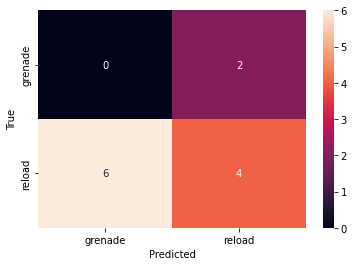

In [15]:
conv1filters = 16
conv1kernel = 15
conv1stride = 15

model = Sequential()
model.add(Conv1D(conv1filters, conv1kernel, strides=conv1stride, activation='relu', input_shape=(window_size, 6)))
model.add(Dropout(0.5)) # 50% dropout
# model.add(Conv1D(32, 40, activation='relu', data_format='channels_first'))
model.add(Flatten())
# model.add(Dense(16, activation='relu'))
model.add(Dense(len(action_types)))
model.add(Softmax())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# performance before training
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [16]:
# checkpoint callback
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# learning rate reduce on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

In [17]:
# Train the model
def train_network(model, train_x, train_y, test_x, test_y):
    verbose = 1 # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
    epochs = 100
    batch_size = 32
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), callbacks = [model_checkpoint_callback, reduce_lr, early_stopping], verbose=verbose)
    _, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
    return model

model = train_network(model, train_x, train_y, test_x, test_y)

Epoch 1/100
2/2 [==============================] - 1s 388ms/step - loss: 110.0797 - accuracy: 0.2609 - val_loss: 66.8759 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/100
2/2 [==============================] - 0s 221ms/step - loss: 62.5152 - accuracy: 0.3913 - val_loss: 43.9422 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 3/100
2/2 [==============================] - 0s 147ms/step - loss: 91.9412 - accuracy: 0.3478 - val_loss: 23.0040 - val_accuracy: 0.6667 - lr: 0.0010
Epoch 4/100
2/2 [==============================] - 0s 187ms/step - loss: 44.7852 - accuracy: 0.5000 - val_loss: 13.6912 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 5/100
2/2 [==============================] - 0s 147ms/step - loss: 24.7527 - accuracy: 0.6522 - val_loss: 7.2383 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/100
2/2 [==============================] - 0s 154ms/step - loss: 27.6062 - accuracy: 0.6087 - val_loss: 2.0895 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 7/100
2/2 [==============================] - 0s 171ms/step 

# Draw confusion matrix

1/1 [==============================] - 0s 14ms/step


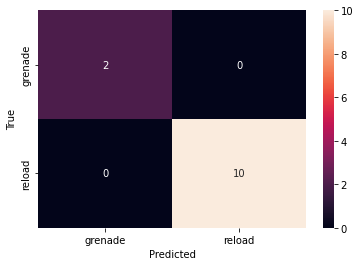

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.load_weights(checkpoint_filepath)
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [30]:
print(f"window shape: {window_size, data_depth}")
print(f"kernel shape: {conv1kernel, data_depth}")
print(f"first layer weights shape: {model.layers[0].get_weights()[0].shape}")
print(f"first layer output shape: {model.layers[0].output_shape}")
print(f"second layer weights shape: {model.layers[3].get_weights()[0].shape}")
print(f"second layer output shape: {model.layers[3].output_shape}")

window shape: (75, 6)
kernel shape: (15, 6)
first layer weights shape: (15, 6, 16)
first layer output shape: (None, 5, 16)
second layer weights shape: (80, 2)
second layer output shape: (None, 2)


In [51]:
# print out weights and biases one by one
layers_indexes = [0, 3]

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    print(weights[0].shape)
    print(f"INPUT_DTYPE model_param_{layer_name}_weights")
    for i in range(weights[0].shape[-1]):
        print("index", i)
        print(weights[0][:][:][i])
    print(f"INPUT_DTYPE model_param_{layer_name}_biases")
    print(weights[1][0])

(15, 6, 16)
INPUT_DTYPE model_param_conv1d_1_weights
index 0
[[ 0.12052298 -0.09943624 -0.09370854  0.05970402  0.05993604 -0.11690275
  -0.1173913   0.09206133 -0.01086064  0.10126384  0.12358414  0.03766169
  -0.09847022  0.04257218 -0.11472235  0.10607135]
 [ 0.11438101 -0.11598659  0.08703531  0.09948251  0.00916242 -0.04511898
  -0.13913643  0.13592534 -0.05867966 -0.01619747  0.02941351 -0.07220794
   0.01675188 -0.00294737 -0.0187601   0.03150725]
 [ 0.08046583  0.00139699  0.02863348 -0.0005086  -0.07289217  0.00882512
  -0.01529271  0.02288463 -0.13369505  0.06398962 -0.04214517  0.00024781
   0.08970419  0.09342994 -0.04675528 -0.11569434]
 [ 0.07354517 -0.01134679  0.08685275  0.03179076 -0.10038668  0.05212996
  -0.03395211  0.05764422 -0.01859641 -0.0033043  -0.02790127 -0.10850722
  -0.04476368  0.03684361 -0.09510451 -0.02322124]
 [ 0.08068027 -0.00111731  0.04890693  0.06362659 -0.06530946  0.12794118
  -0.01886634 -0.00050282  0.0988441  -0.06602345  0.04739724 -0.0352

IndexError: index 15 is out of bounds for axis 0 with size 15

In [34]:
# directly print out weights and biases
layers_indexes = [0, 3]

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    print(f"INPUT_DTYPE model_param_{layer_name}_weights[] = {{")
    weights_to_be_printed = weights[0].reshape(-1)
    # five values per line
    n_values_per_line = 10
    for i in range(0, len(weights_to_be_printed), n_values_per_line):
        print(", ".join([str(round(x, 20)) for x in weights_to_be_printed[i:i+n_values_per_line]]) + ",")
    print("};")
    print(f"INPUT_DTYPE model_param_{layer_name}_biases[] = {{")
    # print n values per line
    for i in range(0, len(weights[1]), n_values_per_line):
        print(", ".join([str(round(x, 20)) for x in weights[1][i:i+n_values_per_line]]) + ",")
    print("};")

conv1d_1
INPUT_DTYPE model_param_softmax_weights[] = {
0.120522976, -0.09943624, -0.09370855, 0.05970402, 0.059936043, -0.116902746, -0.117391296, 0.092061326, -0.010860644, 0.10126384,
0.12358414, 0.03766169, -0.09847022, 0.042572178, -0.11472235, 0.106071346, 0.11438101, -0.11598659, 0.08703531, 0.099482514,
0.00916242, -0.045118976, -0.13913643, 0.13592534, -0.05867966, -0.016197467, 0.029413506, -0.072207935, 0.016751878, -0.002947372,
-0.018760096, 0.031507246, 0.08046583, 0.001396993, 0.028633485, -0.0005086009, -0.072892174, 0.008825117, -0.0152927125, 0.022884633,
-0.13369505, 0.063989624, -0.04214517, 0.00024781405, 0.089704186, 0.09342993, -0.04675528, -0.115694344, 0.073545165, -0.011346791,
0.08685275, 0.031790756, -0.10038668, 0.05212996, -0.03395211, 0.057644222, -0.018596405, -0.003304301, -0.02790127, -0.108507216,
-0.04476368, 0.036843613, -0.095104516, -0.023221234, 0.080680266, -0.00111731, 0.04890693, 0.063626595, -0.065309465, 0.12794118,
-0.01886634, -0.0005028191

In [72]:
# directly print out test dataset
n_values_per_line = 10
dataset_size = test_x.shape[0]
print("#define DATASET_SIZE", dataset_size)

print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(0, test_x.shape[0]):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(round(x, 10)) for x in test_x[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(0, test_x.shape[0]):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

#define DATASET_SIZE 12
const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {
-132.6875, -43.78125, -13.6875, 23.65625, -20.6875, -59.593754,
-136.71875, -49.4375, -11.65625, 28.75, -28.375, -90.125,
-140.8125, -54.53125, -8.96875, 45.34375, -41.53125, -115.90625,
-144.65625, -59.375, -6.5, 64.78125, -59.0625, -149.9375,
-147.90625, -62.5, -4.375, 103.59375, -80.5625, -172.125,
-149.9375, -63.0625, -2.5625, 121.34374, -100.125, -185.34375,
-150.90625, -62.71875, -1.25, 106.34375, -114.78124, -191.84375,
-151.25, -63.59375, -0.46874997, 84.1875, -121.40625, -200.6875,
-151.0, -65.8125, -0.3125, 77.78125, -125.9375, -206.625,
-149.59375, -68.53125, -0.5, 83.40625, -129.53125, -213.40625,
-147.0625, -70.46875, -0.6875, 95.40625, -131.28125, -224.25002,
-141.8125, -71.25, -1.40625, 105.6875, -145.46875, -231.28127,
-136.53125, -70.40625, -1.9375, 102.78125, -141.96875, -224.09375,
-128.09375, -68.96875, -2.90625, 93.625, -140.28125, -214.28125,
-116.5625, -64.4375, -4.40625, 67.7

In [26]:
# print model output without the last layer
from keras.models import Model
model_without_last_layer = Model(inputs=model.input, outputs=model.layers[-5].output)
model_without_last_layer.summary()
predicted_result = model_without_last_layer.predict(test_x)[0]
print(predicted_result.shape)
print(predicted_result)


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1_input (InputLayer)  [(None, 75, 6)]          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 16)             1456      
                                                                 
Total params: 1,456
Trainable params: 1,456
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 38ms/step
(5, 16)
[[ 0.        0.        0.       68.053276 20.126944  0.        0.
   0.       74.87098   0.       37.962566  0.       33.376404 19.353777
  60.969425 64.56446 ]
 [ 0.        0.        0.       51.856903 28.703922  0.        0.
   0.       70.14499   0.       43.675545  0.       35.562366 25.411602
  68.64261  76.09152 ]
 [ 0.        0.        0.       67.46219  21.894384  0.        0.
   0.